In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import os, glob
import sys

# Add the path to the directory containing the module
import sys
sys.path.append('../../')
from util.ml import baseline, metrics, nestedMLR

/Users/itam/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare and train the nestedMLR models

### Read X and y files

In [2]:
! ls ../../datas/proc/old/part2/X_old/

1   102 42  45


In [3]:
# Find the folder name organized by seed number
seed_docs = sorted(glob.glob('../../datas/seed_*/'))

# Model complexity
n_vars = 5

# Seed number
seed = 102

# Store different seeds
Xtrains = []
Xvalids = []
Xtests  = []
ytrains = []
yvalids = []
ytests  = []
sizes = []
# Load the data
for ind,obj in enumerate(seed_docs):
    # Load the y data
    ytrain = {'max': pd.read_csv(obj + 'y_train_max.csv', header=None).iloc[1:,:].reset_index().drop(columns='index'), 
              'cdf': pd.read_csv(obj + 'y_train_cdf.csv', header=None).iloc[1:,:].reset_index().drop(columns='index')}
    yvalid = {'max': pd.read_csv(obj + 'y_validation_max.csv', header=None).iloc[1:,:].reset_index().drop(columns='index'), 
              'cdf': pd.read_csv(obj + 'y_validation_cdf.csv', header=None).iloc[1:,:].reset_index().drop(columns='index')}
    ytest  = {'max': pd.read_csv(obj + 'y_test_max.csv', header=None).iloc[1:,:].reset_index().drop(columns='index'), 
              'cdf': pd.read_csv(obj + 'y_test_cdf.csv', header=None).iloc[1:,:].reset_index().drop(columns='index')}

    # Load the x data
    X_nonorml_train = baseline.load_pickle(f'../../datas/proc/old/part2/X_old/{seed}/' + f'X_train_{n_vars}.pkl')['X'][ind]
    X_nonorml_valid = baseline.load_pickle(f'../../datas/proc/old/part2/X_old/{seed}/' + f'X_valid_{n_vars}.pkl')['X'][ind]
    X_nonorml_test  = baseline.load_pickle(f'../../datas/proc/old/part2/X_old/{seed}/' + f'X_test_{n_vars}.pkl')['X'][ind]

    # Load the size data
    sizes.append(baseline.load_pickle(f'../../datas/proc/old/part2/X_old/{seed}/' + f'X_train_{n_vars}.pkl')['varsize'][ind])

    # Normalize the data
    scaler = StandardScaler().fit(X_nonorml_train)
    Xtrain = scaler.transform(X_nonorml_train)
    Xvalid = scaler.transform(X_nonorml_valid)
    Xtest  = scaler.transform(X_nonorml_test)

    # Store the data
    Xtrains.append(Xtrain)
    Xvalids.append(Xvalid)
    Xtests.append(Xtest)
    ytrains.append(ytrain)
    yvalids.append(yvalid)
    ytests.append(ytest)



### Define nestedMLR model

In [4]:
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [5]:
model = nestedMLR.nestedMLR_var_global(sizes[0],seed+4, 2.25)
model.fit(Xtrains[0], ytrains[0]['cdf'].values)

nestedMLR_var_global(bounds=2.25, seed=106, sizes=[5, 4, 6, 10, 5])

In [6]:
model.predict(Xvalids[0])[1], yvalids[0]['cdf'].values[1]

(array([1.19187429, 1.21124892, 1.5803408 , 2.57322299, 0.90994486,
        0.49344803, 2.4276083 , 0.96256355, 0.38575858, 1.44150573,
        1.39710525, 1.88982622, 2.01394232, 1.16560547, 2.31961081]),
 array([2.83267521, 2.82178632, 0.67042071, 4.06922139, 1.21347463,
        0.28077558, 3.75805739, 0.91023414, 0.26891327, 0.06098095,
        0.66373998, 1.46091615, 0.48655505, 0.36195404, 0.50447758]))

In [6]:
model.predict(Xvalids[0])[1], yvalids[0]['cdf'].values[1]

(array([1.19218017, 1.21176434, 1.58076396, 2.5730824 , 0.9098408 ,
        0.49386769, 2.42747948, 0.96246302, 0.38536994, 1.44212455,
        1.39659644, 1.89058442, 2.01545162, 1.16522457, 2.31721984]),
 array([2.83267521, 2.82178632, 0.67042071, 4.06922139, 1.21347463,
        0.28077558, 3.75805739, 0.91023414, 0.26891327, 0.06098095,
        0.66373998, 1.46091615, 0.48655505, 0.36195404, 0.50447758]))

In [23]:
def find_best_seed(Xtrain, ytrain, Xvalid, yvalid, size, numseed=1000, TYPE='cdf'):
    best_seed = None
    best_r2 = -np.inf
    
    for seed in tqdm(range(numseed)):
        model = nestedMLR.nestedMLR_var_sfgo(size,seed)
        model.fit(Xtrain, ytrain[TYPE].values)

        ypred = model.predict(Xvalid)
        r2valid = r2_score(yvalid[TYPE].values, model.predict(Xvalid))

        if r2valid > best_r2:
            best_seed = seed
            best_r2 = r2valid
    return best_seed, best_r2, model

In [28]:
for i in range(10):
    bestseed, bestvalid_r2, model = find_best_seed(Xtrains[i], ytrains[i], Xvalids[i], yvalids[i], sizes[i], 100, 'cdf')
    dict_store = {'bestseed': bestseed, 'bestvalid_r2': bestvalid_r2,'bestmodel': model}
    baseline.save_models(dict_store, f'../../datas/proc/part2/nestedMLR/{seed}/cv_{i+1}_var_{n_vars}_bestmodel.pkl')

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


In [31]:
model.weights

{'dense1': array([-0.14235884,  2.05722174,  0.28326194,  1.32981198, -0.15462185]),
 'dense2': array([-0.06903086,  0.75518049,  0.82564665, -0.11306921]),
 'dense3': array([-2.36783759, -0.16704943,  0.68539797,  0.02350011,  0.45620128,
         0.27049278]),
 'dense4': array([-1.43500814,  0.88281715, -0.58008166, -0.5015653 ,  0.59095329,
        -0.73161625,  0.26175546, -0.85579558, -0.18752591, -0.37348629]),
 'dense5': array([-0.46197097, -0.8164661 , -0.0451233 ,  0.12132778,  0.92595278]),
 'output': array([[ 0.43333402, -1.70429169, -0.24390807, -2.13970379,  0.86132265,
          1.7002844 , -0.5287848 ,  1.76347792, -1.12160783, -1.19193417,
          0.55273192, -0.81598095, -0.49664685,  1.08622556, -0.97467528],
        [-0.28213582, -0.11721415,  0.37854727,  0.73219465, -0.10357103,
         -1.19870628,  1.01003558,  2.87536033,  0.82031264,  0.56061151,
         -0.3756422 , -0.2521043 , -1.38961345,  0.61733228, -0.13578705],
        [ 1.28790496, -1.0369944 ,  1.

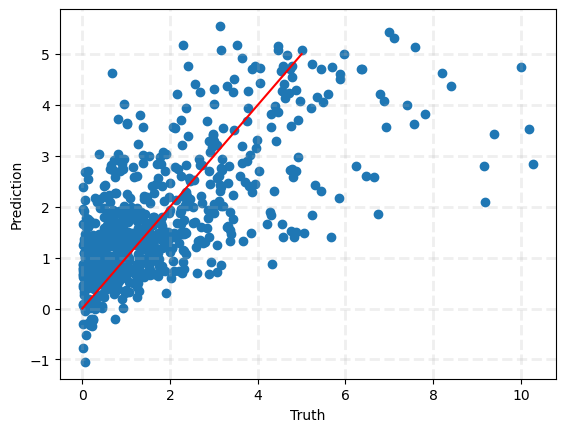

In [18]:
plt.scatter(ytrains[0]['cdf'],model.predict(Xtrains[0]))
# Add 1-1 line
plt.plot([0,5],[0,5], color='red')
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

In [51]:
nested_list = [x for pair in zip(weights, biases) for x in pair]
[item for sublist in nested_list for item in (sublist if isinstance(sublist, list) else [sublist])]

[0.3, 0.3, 0.3, 0.1, 0.4, 0.4, 0.4, 0.4, 0.1]